# ----------------------------------------------------------------------
# Mutex Runs
# ----------------------------------------------------------------------

### Set parameters

In [72]:
mutationmatrix = '/Users/jlu96/maf/new/OV_broad/OV_broad-som.m2'

patientFile = '/Users/jlu96/maf/new/OV_broad/shared_patients.plst'
segment_info_file = "/Users/jlu96/maf/new/OV_broad/segment_info_som.txt"
file_prefix = '/Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som-'
test_minFreq_ratio = 0.04
minPatientPercentile = 50
cpairPercentile = 0.15
mpairPercentile = 0.03

Score is  2.0


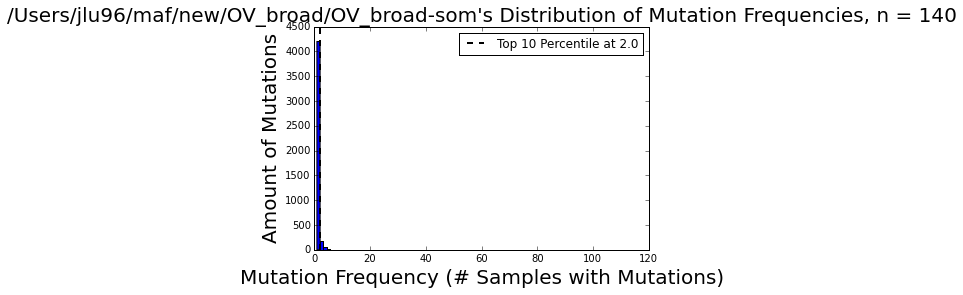

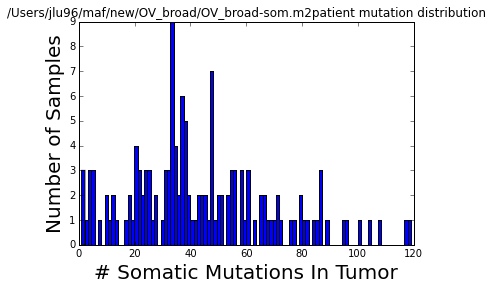


**********WITHIN SMALLEST CLUSTER**********
Smallest cluster patients is  72
number genes in smallest cluster is  1532
Mutation frequency threshold is  2
number of genes above threashold  134
Score is  1.0


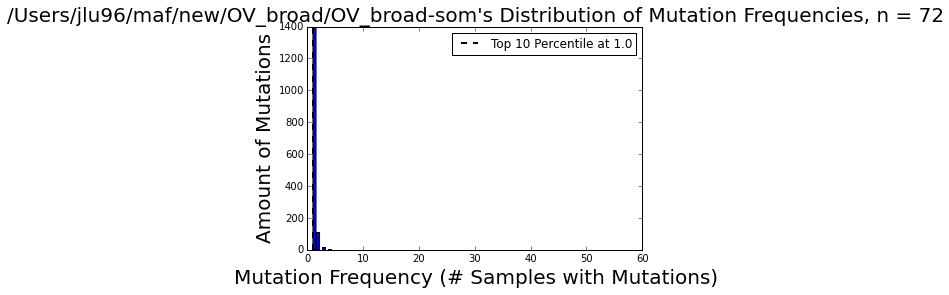

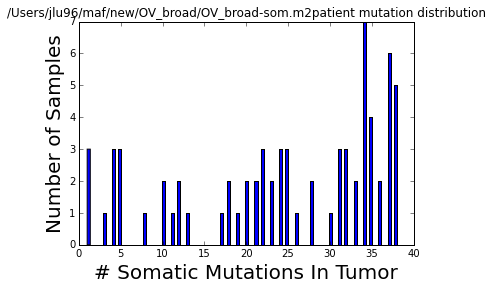


**********GETTING PAIRS**********
segment  FAM190B not in dictionary. Default to Chromosome Z.
segment  C10orf137 not in dictionary. Default to Chromosome Z.
segment  CTSL1 not in dictionary. Default to Chromosome Z.
segment  ZFP112 not in dictionary. Default to Chromosome Z.
segment  FAM113B not in dictionary. Default to Chromosome Z.
Number of pairs to test:  8513
Number of pairs is  8513  retrieved in time :  5.97470402718


0

In [73]:
# Look at top segments. Same filters.


# Let's try limiting the significant co-occurrent pairs and see if we can increase our power
# Let's consider the 100 least mutated patients and search for co-occurrence within them

import mutex as mex
import csv
import mutex_triangles as met
import chisquared as chi
import bingenesbypairs as bgbp
import time
import os
import scipy.stats as stats
import partition as par
import numpy as np
%matplotlib inline


pairfile = file_prefix + 'pairs-min_cohort.txt'
triplet_file_prefix = file_prefix + '-triplets-'
new_pairfile = file_prefix + "-pairs-min_cohort_filtered.txt"
new_cpairfile = file_prefix + "-cpairs-min_cohort_filtered.txt"
new_mpairfile = file_prefix + "-mpairs-min_cohort_filtered.txt"
geneFile = None
minFreq = 0
compute_mutex = True
closer_than_distance = 100000000


numGenes, numCases, genes, patients, geneToCases, patientToGenes = mex.load_mutation_data(mutationmatrix, patientFile, geneFile, minFreq)

mex.graph_mutation_distribution(numCases, genes, geneToCases, filename=mutationmatrix, bins=100)
mex.graph_patient_distribution(len(genes), patients, patientToGenes, mutationmatrix + "patient mutation distribution")


print "\n**********WITHIN SMALLEST CLUSTER**********"
D = [len(patientToGenes[p]) for p in patientToGenes]
minThreshold = stats.scoreatpercentile(D, minPatientPercentile)

c0patients = [p for p in patientToGenes if len(patientToGenes[p]) <= minThreshold]

c0cohort_dict = {0: c0patients}

c0genes, c0geneToCases, c0patientToGenes = par.get_cluster_gTC_pTG(geneToCases, patientToGenes, c0patients)

print "Smallest cluster patients is ", len(c0patients) 

print "number genes in smallest cluster is ", len(c0genes)

test_minFreq = int( test_minFreq_ratio * len(c0patients))
print "Mutation frequency threshold is ", test_minFreq

print "number of genes above threashold ", len([g for g in c0genes if len(c0geneToCases[g]) >= test_minFreq])


mex.graph_mutation_distribution(len(c0patients), c0genes, c0geneToCases, filename=mutationmatrix + "-min-cohort", bins=100)
mex.graph_patient_distribution(len(genes), c0patients, c0patientToGenes, mutationmatrix + "patient mutation distribution")


print "\n**********GETTING PAIRS**********"
reload(bgbp)
t = time.time()
genepairs = bgbp.getgenepairs(c0geneToCases, c0genes, test_minFreq=test_minFreq, closer_than_distance=closer_than_distance)
print "Number of pairs is ", len(genepairs), " retrieved in time : ", time.time() - t

os.system('say "exploration finished"')

## Run through the pairs

In [74]:
print "Getting normal statistics..."
t = time.time()
pairsdict, genedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, genepairs, compute_mutex=compute_mutex)
print "Finished in ", time.time() - t

print "Testing within the smallest cluster..."
t = time.time()
pairsdict = chi.add_BinomP_cohorts_all_pairs(pairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
print "Finished in ", time.time() - t
print "Writing to file...",  pairfile

fieldnames = (pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')


fieldnames.insert(2, 'Type')
fieldnames.insert(3, '1CBinomProb0')
fieldnames.insert(3, '1MBinomProb0')

met.writeanydict(pairsdict, pairfile, fieldnames=fieldnames)
os.system('say "min cohort pairs finished"')

Getting normal statistics...
Finished in  62.3612179756
Testing within the smallest cluster...
Finished in  4.58751106262
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som-pairs-min_cohort.txt


0

## Plot initial run through, find pairs to test

Top  0.15 percent of cooccurring pairs:  0.0442540466662
Top  0.03 percent of mutually exclusive pairs :  0.505044923126
Now number of mutex pairs to test  3
Now number of coocurr pairs to test  14
Number of genes  23


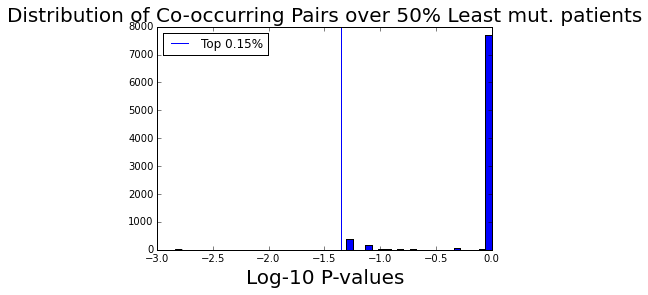

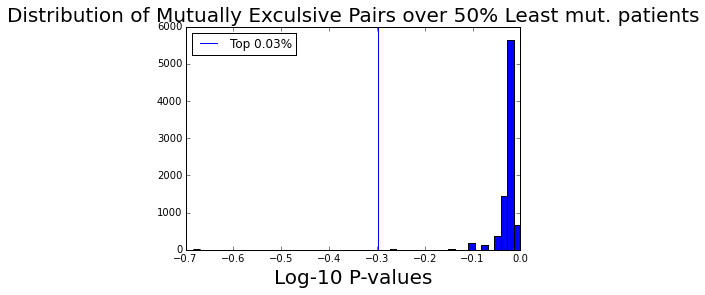

In [75]:
import matplotlib.pyplot as plt

%matplotlib inline
cpvalues = np.array([pairsdict[c]['1CBinomProb0'] for c in pairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([pairsdict[c]['1MBinomProb0'] for c in pairsdict])
logmp = np.log10(mpvalues)

threshold = 0.05/len(logcp)

cthreshold = stats.scoreatpercentile(cpvalues, cpairPercentile)
mthreshold = stats.scoreatpercentile(mpvalues, mpairPercentile)
print "Top ", cpairPercentile, "percent of cooccurring pairs: ", cthreshold
print "Top ", mpairPercentile, "percent of mutually exclusive pairs : ", mthreshold

# Let's get the top 10 percent of pairs

goodcpairs = [c for c in pairsdict if (pairsdict[c]['1CBinomProb0'] <= cthreshold)]
goodmpairs = [c for c in pairsdict if (pairsdict[c]['1MBinomProb0'] <= mthreshold)]
goodpairs = goodcpairs + goodmpairs
goodgenes = set.union(*(set(goodpair) for goodpair in goodpairs))
print "Now number of mutex pairs to test ", len(goodmpairs)
print "Now number of coocurr pairs to test ", len(goodcpairs)
print "Number of genes ", len(goodgenes)

plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x= np.log10(cthreshold), label="Top " + str(cpairPercentile) + "%")
plt.title("Distribution of Co-occurring Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()




threshold = 0.05/len(logmp)

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x= np.log10(mthreshold), label="Top " + str(mpairPercentile) + "%")
plt.title("Distribution of Mutually Exculsive Pairs over " + str(minPatientPercentile) + "% Least mut. patients", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()



### Test new pairs

In [76]:
print "Getting normal statistics across whole distribution"

new_mpairsdict, new_mgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodmpairs, compute_mutex=compute_mutex)
new_cpairsdict, new_cgenedict = met.cooccurpairs(numCases, geneToCases, patientToGenes, goodcpairs, compute_mutex=compute_mutex)

print "Testing across the whole distribution"

new_mpairsdict = chi.add_BinomP_cohorts_all_pairs(new_mpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)
new_cpairsdict = chi.add_BinomP_cohorts_all_pairs(new_cpairsdict, geneToCases, patientToGenes, c0cohort_dict, c0patients)

new_pairsdict = new_mpairsdict.copy()
new_pairsdict.update(new_mpairsdict)


print "Writing to file...", new_pairfile

fieldnames = (new_pairsdict.values()[0]).keys()
fieldnames.remove('MutationFrequencies')
fieldnames.remove('MutationFrequencyDifference')
fieldnames.remove('MutationFrequencyDifferenceRatio')
fieldnames.remove('CooccurrenceRatio')
fieldnames.remove('Coverage')
fieldnames.remove('SetScore')
fieldnames.remove('AverageOverlapPMN')
fieldnames.remove('CombinedScore')
fieldnames.remove('Concordance')
fieldnames.remove('Somatic')
fieldnames.remove('RoundedLogPCov')
fieldnames.remove('GeneSet')
fieldnames.remove('Type')

fieldnames.insert(2, 'Type')
fieldnames.insert(3, 'AllMBinomProb')
fieldnames.insert(3, 'AllCBinomProb')

met.writeanydict(new_pairsdict, new_pairfile, fieldnames=fieldnames)

os.system('say "whole distribution pairs finished"')

Getting normal statistics across whole distribution
Testing across the whole distribution
Writing to file... /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som--pairs-min_cohort_filtered.txt


0

### Plot results

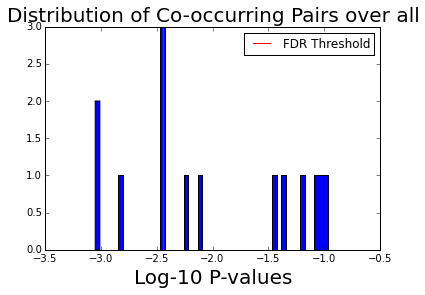

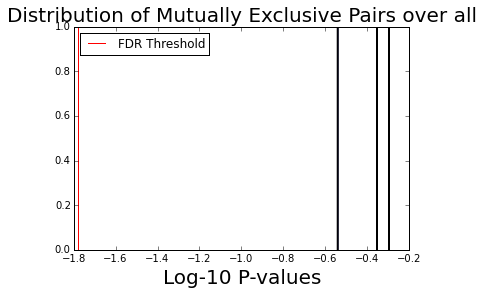

Number significant mutex 0
Number significant coocurr 6


In [77]:
import matplotlib.pyplot as plt

%matplotlib inline
# Left off here: jonathan
cpvalues = np.array([new_cpairsdict[c]['AllCBinomProb'] for c in new_cpairsdict])
logcp = np.log10(cpvalues)
mpvalues = np.array([new_mpairsdict[c]['AllMBinomProb'] for c in new_mpairsdict])
logmp = np.log10(mpvalues)

cthreshold = 0.05/len(logcp)
mthreshold = 0.05/len(logmp)
                            
plt.figure()
plt.hist(logcp, bins=50)
plt.axvline(x=np.log10(cthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Co-occurring Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()

plt.figure()
plt.hist(logmp, bins=50)
plt.axvline(x=np.log10(mthreshold), label="FDR Threshold", c='r')
plt.title("Distribution of Mutually Exclusive Pairs over all", fontsize=20)
plt.xlabel("Log-10 P-values", fontsize=20)
plt.legend(loc='best')
plt.show()


# filter all the pairs




        
# Split into mutex and cooccur
new_sig_m_dict = new_mpairsdict.copy()
new_sig_c_dict = new_cpairsdict.copy()

for pair in new_mpairsdict:
    if new_sig_m_dict[pair]['AllMBinomProb'] > mthreshold:
        new_sig_m_dict.pop(pair)

for pair in new_cpairsdict:
    if new_sig_c_dict[pair]['AllCBinomProb'] > cthreshold:
        new_sig_c_dict.pop(pair)
print "Number significant mutex", len(new_sig_m_dict)
print "Number significant coocurr", len(new_sig_c_dict)


new_sig_dict = new_sig_m_dict.copy()
new_sig_dict.update(new_sig_c_dict)
# new_sig_dict = new_pairsdict.copy()
# for pair in new_pairsdict:
#     if new_sig_dict[pair]['AllCBinomProb'] > cthreshold and new_sig_dict[pair]['AllMBinomProb'] > mthreshold:
#         new_sig_dict.pop(pair)

## Mutual exclusivity info

In [78]:


bgbp.write_segment_infos(goodgenes, segment_info_file)



print "*********MUTUAL EXCLUSIVITY INFO**********\n"

print len(new_sig_m_dict), "mutually exclusive pairs"

mfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllMBinomProb', 
                'AllFreqs', 'AllOverlap', 'AllSize','1MBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_m_dict = {}
cyto_m_dict = {}
cyto_pair_m_dict = {}

for pair in new_sig_m_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene0'])
    new_sig_m_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_m_dict[pair]['Gene1'])
    new_sig_m_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_m_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_m_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_m_dict[pair]['Gene0'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene0']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene0']].add(pair)
    if new_sig_m_dict[pair]['Gene1'] not in gene_m_dict:
        gene_m_dict[new_sig_m_dict[pair]['Gene1']] = set()
    gene_m_dict[new_sig_m_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info0['Cytobands'])] = set()
    cyto_m_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_m_dict:
        cyto_m_dict[str(info1['Cytobands'])] = set()
    cyto_m_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_m_dict:
        cyto_pair_m_dict[cyto_pair] = set()
        
    cyto_pair_m_dict[cyto_pair].add(pair)


if new_sig_m_dict:
    for key in new_sig_m_dict[pair].keys():
        if key not in mfieldnames:
            mfieldnames.append(key)
    

orderedmpairs = sorted(new_sig_m_dict.keys(), key=lambda entry: (new_sig_m_dict[entry]['AllMBinomProb'],))
    
met.writeanydict(new_sig_m_dict, new_mpairfile, fieldnames=mfieldnames, orderedkeys=orderedmpairs)
print "updated with segment info ", new_mpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_mpairfile -o $new_mpairfile
print "updated with COSMIC info ", new_mpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_m_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********MUTUAL EXCLUSIVITY INFO**********

0 mutually exclusive pairs
updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som--mpairs-min_cohort_filtered.txt
updated with COSMIC info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som--mpairs-min_cohort_filtered.txt

**********SINGLE GENES**********

**********SINGLE CYTOBANDS**********

**********PAIRED CYTOBANDS**********


0

## Co-occurrence info

In [79]:
bgbp.write_segment_infos(goodgenes, segment_info_file)




print "*********COOCCURRENCE INFO**********\n"

print len(new_sig_c_dict), "co-occurring pairs"

cfieldnames = ['Gene0', 'Gene1', 'Gene0Cytobands', 'Gene1Cytobands', 'AllCBinomProb', 
               'AllFreqs', 'AllOverlap', 'AllSize','1CBinomProb0', '1Freqs0', '1Overlap0',
               '1Size0']


gene_c_dict = {}
cyto_c_dict = {}
cyto_pair_c_dict = {}

for pair in new_sig_c_dict:
    info0 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene0'])
    new_sig_c_dict[pair]['Gene0Loc'] = str(info0['Chromosome']) + ':' + str(info0['Start'])
    info1 = bgbp.get_segment_gene_info(new_sig_c_dict[pair]['Gene1'])
    new_sig_c_dict[pair]['Gene1Loc'] = str(info1['Chromosome']) + ':' + str(info1['Start'])
    new_sig_c_dict[pair]['Gene0Cytobands'] = str(info0['Cytobands'])
    new_sig_c_dict[pair]['Gene1Cytobands'] = str(info1['Cytobands'])
    
    
    if new_sig_c_dict[pair]['Gene0'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene0']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene0']].add(pair)
    if new_sig_c_dict[pair]['Gene1'] not in gene_c_dict:
        gene_c_dict[new_sig_c_dict[pair]['Gene1']] = set()
    gene_c_dict[new_sig_c_dict[pair]['Gene1']].add(pair)
    
    
    
    if str(info0['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info0['Cytobands'])] = set()
    cyto_c_dict[str(info0['Cytobands'])].add(pair)
    if str(info1['Cytobands']) not in cyto_c_dict:
        cyto_c_dict[str(info1['Cytobands'])] = set()
    cyto_c_dict[str(info1['Cytobands'])].add(pair)
    
    
    
    cyto_pair = frozenset([str(info0['Cytobands']), str(info1['Cytobands'])])
    
    if cyto_pair not in cyto_pair_c_dict:
        cyto_pair_c_dict[cyto_pair] = set()
        
    cyto_pair_c_dict[cyto_pair].add(pair)
    
# Writing to file
if new_sig_c_dict:
    for key in new_sig_c_dict[pair].keys():
        if key not in cfieldnames:
            cfieldnames.append(key)
    
orderedcpairs = sorted(new_sig_c_dict.keys(), key=lambda entry: (new_sig_c_dict[entry]['AllCBinomProb'],))
    
met.writeanydict(new_sig_c_dict, new_cpairfile, fieldnames=cfieldnames, orderedkeys=orderedcpairs)
print "updated with segment info ", new_cpairfile
!python add_COSMIC.py -ic Gene0 Gene1 -ip $COSMIC_pair_insertion_index -i $new_cpairfile -o $new_cpairfile
print "updated with COSMIC info ", new_cpairfile


# Writing gene infos
    

sorted_genes = sorted(gene_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytobands = sorted(cyto_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
sorted_cytotuples = sorted(cyto_pair_c_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

print "\n**********SINGLE GENES**********"
print_length = 15
for gene in sorted_genes:
    if len(gene[0]) <= print_length + 4:
        print gene[0], "has", len(gene[1])
    else:
        print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

print "\n**********SINGLE CYTOBANDS**********"
for cytoband in sorted_cytobands:
    print cytoband[0], "has", len(cytoband[1])

print "\n**********PAIRED CYTOBANDS**********"
for cytotuple in sorted_cytotuples:
    print  cytotuple[0], "has", len(cytotuple[1])


os.system('say "finished"')

*********COOCCURRENCE INFO**********

6 co-occurring pairs
updated with segment info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som--cpairs-min_cohort_filtered.txt
updated with COSMIC info  /Users/jlu96/conte/jlu/Analyses/CooccurImprovement/LorenzoModel/Binomial/OV_broad-som--cpairs-min_cohort_filtered.txt

**********SINGLE GENES**********
PPARGC1A has 2
PPP1R3A has 1
PKD1L2 has 1
CASP1 has 1
CDK12 has 1
FAM47A has 1
MAP2 has 1
ASTN2 has 1
CNTNAP5 has 1
HECW1 has 1
NLRP11 has 1

**********SINGLE CYTOBANDS**********
['4p15.2'] has 2
['7q31.1'] has 1
['2q14.3'] has 1
['9q32'] has 1
['19q13.42'] has 1
['7p14.1', '7p13'] has 1
['Xp21.1'] has 1
['17q21.2'] has 1
['2q34'] has 1
['16q23.2'] has 1
['11q22.3'] has 1

**********PAIRED CYTOBANDS**********
frozenset(["['2q14.3']", "['9q32']"]) has 1
frozenset(["['Xp21.1']", "['7p14.1', '7p13']"]) has 1
frozenset(["['4p15.2']", "['16q23.2']"]) has 1
frozenset(["['11q22.3']", "['19q13.42']"]) has 1
frozenset([

0

## Search for triplets

In [80]:
# Search for triplets
import mutex_triangles as met
import edgereader as edg


        
    
    
# Search for triplets
import mutex_triangles as met
import edgereader as edg

genedict = edg.get_gene_dict(new_sig_dict)
Triplets, pairsdict_Triplets, sorted_pairs, genesdict_Triplets, sorted_genes = met.getTriplets(new_sig_dict, genedict, new_sig_dict, numCases, geneToCases=geneToCases, patientToGenes=patientToGenes)
Triplet_dict = met.sort_triplets_by_type(Triplets)

for t_type in Triplet_dict:
    print len(Triplet_dict[t_type]), " of type ",  t_type
    Triplet_dict[t_type] = sorted(Triplet_dict[t_type], key=lambda entry: entry.stats['Count'], reverse=True)
    triplet_file_name = triplet_file_prefix + t_type + '.txt'
    met.writeTriplets2(Triplet_dict[t_type], triplet_file_name)
    !python add_COSMIC.py -ic Gene0 Gene1 Gene2 -ip $COSMIC_triplet_insertion_index -i $triplet_file_name -o $triplet_file_name
    print "updated with COSMIC info ", triplet_file_name
    
    
    
    print "*********" + str(t_type) + "INFO**********\n"
    gene_t_dict = {}
    cyto_t_dict = {}
    cyto_trip_t_dict = {}
    
    
    # LEFT OFF HERE-JLU
    
    for triplet in Triplet_dict[t_type]:
        genes = triplet.genes
        
        cytobands = set([str(bgbp.get_segment_gene_info(gene)['Cytobands']) for gene in genes])
        
        for gene in genes:
            if gene not in gene_t_dict:
                gene_t_dict[gene] = set()
            gene_t_dict[gene].add(frozenset(genes.difference(set([gene]))))
    
        
        for cytoband in cytobands:
            if cytoband not in cyto_t_dict:
                cyto_t_dict[cytoband] = set()
            cyto_t_dict[cytoband].add(frozenset(cytobands.difference(set([cytoband]))))
    
        if frozenset(cytobands) not in cyto_trip_t_dict:
            cyto_trip_t_dict[frozenset(cytobands)] = set()
            
        cyto_trip_t_dict[frozenset(cytobands)].add(frozenset(genes))
    
    
    

    sorted_genes = sorted(gene_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytobands = sorted(cyto_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)
    sorted_cytotuples = sorted(cyto_trip_t_dict.items(), key = lambda entry: len(entry[1]), reverse=True)

    print "\n**********SINGLE GENES**********"
    print_length = 15
    for gene in sorted_genes:
        if len(gene[0]) <= print_length + 4:
            print gene[0], "has", len(gene[1])
        else:
            print gene[0][0:print_length] + gene[0][-4:], "has\t", len(gene[1])

    print "\n**********SINGLE CYTOBANDS**********"
    for cytoband in sorted_cytobands:
        print cytoband[0], "has", len(cytoband[1])

    print "\n**********PAIRED CYTOBANDS**********"
    for cytotuple in sorted_cytotuples:
        print  cytotuple[0], "has", len(cytotuple[1])


    os.system('say "finished"')



number of pairs  6
Pair info of triplets initialized
0  triplets calculated in  0.000578880310059
Including sorting time  0.000784873962402
